In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests
import scipy.optimize as sopt
import scipy.stats as s
import scipy.interpolate as inter
from statsmodels.tsa.stattools import adfuller


Timestamp('2017-12-01 00:00:00')

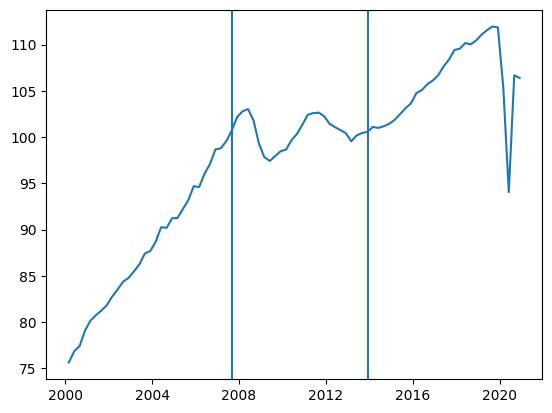

In [12]:
Case = pd.read_csv('/home/francesco/Codici/Computazionale/DC2/Italia/ripuliti/Case_Ripulite.csv')
Lavoratori = pd.read_csv('/home/francesco/Codici/Computazionale/DC2/Italia/ripuliti/Lavoratori_Pulito.csv')
Permessi = pd.read_csv('/home/francesco/Codici/Computazionale/DC2/Italia/ripuliti/Permessi_Ripuliti.csv')
PIL = pd.read_csv('/home/francesco/Codici/Computazionale/DC2/Italia/ripuliti/PIL_Ripuliti.csv')
Popolazione = pd.read_csv('/home/francesco/Codici/Computazionale/DC2/Italia/ripuliti/Popolazione_Ripulita.csv')
Tassi = pd.read_csv('/home/francesco/Codici/Computazionale/DC2/Italia/ripuliti/Tassi_Ripuliti.csv')
#Turisti = pd.read_csv('/home/francesco/Codici/Computazionale/DC2/Italia/ripuliti/Turisti_ripuliti.csv')

datasets = [Case , Lavoratori , Permessi , PIL , Popolazione , Tassi ]

for i in datasets : 
    i.TIME = pd.to_datetime(i.TIME)
    i.TIME = i.TIME.apply(lambda dt : dt.replace(day = 1))
    i.sort_values('TIME', inplace = True)
tot = Case
datasets = [ Lavoratori , Permessi , PIL , Popolazione , Tassi ]

for i in datasets : tot = tot.merge(i , on = 'TIME')

datasets = [Case , Lavoratori , Permessi , PIL , Popolazione , Tassi]
tot.drop_duplicates(subset = 'TIME', inplace = True , ignore_index=True)
tot.drop(columns=['Year','Tipo aggregato (milioni di euro)' , 'Tipo dato' , 'Edizione_x' , 'Edizione_y' , 'Tipologia edilizia' , 'Valutazione' , 'Entity' , 'Code'] , inplace = True)
tot.rename(columns = {'Case_Nuove' : 'Permessi' , 'Population (historical estimates)' : 'Popolazione' , 'Index_Case' : 'Case'} , inplace = True )

Media = tot[tot.TIME.dt.year == 2010] 
tot.sort_values(by = 'TIME', inplace = True)
tot.Lavoratori = tot.Lavoratori/ Media.Lavoratori.mean() * 100 
tot.Permessi = tot.Permessi/ Media.Permessi.mean() * 100
tot.PIL = tot.PIL/ Media.PIL.mean() * 100 
tot.Tassi = tot.Tassi/ Media.Tassi.mean() * 100 
tot.Popolazione = tot.Popolazione/ Media.Popolazione.mean() * 100 
#tot.Turisti = tot.Turisti/ Media.Turisti.mean() *100
tot.idxmax()
plt.plot(tot['TIME'], tot['PIL'])
plt.axvline(x = tot['TIME'][30])
plt.axvline(x = tot['TIME'][55])
tot['TIME'][71]


In [13]:
tot.TIME.min()


Timestamp('2000-03-01 00:00:00')

In [14]:
def traslo( Dataset) :     
    x_Dataset = pd.to_numeric(Dataset.TIME)
    y = Dataset.Permessi
    slope, intercept, r, p, se = s.linregress(x_Dataset, y)
    Traslati_Permessi =  y - slope * x_Dataset - intercept
    
    y = Dataset.Case
    slope, intercept, r, p, se = s.linregress(x_Dataset, y)
    Traslati_Case =  y - slope * x_Dataset - intercept 
    
    y = Dataset.Lavoratori
    slope, intercept, r, p, se = s.linregress(x_Dataset, y)
    Traslati_Lavoratori =  y - slope * x_Dataset - intercept 
    
    y = Dataset.PIL
    slope, intercept, r, p, se = s.linregress(x_Dataset, y)
    Traslati_PIL =  y - slope * x_Dataset - intercept 
    
    y = Dataset.Popolazione
    slope, intercept, r, p, se = s.linregress(x_Dataset, y)
    Traslati_Popolazione =  y - slope * x_Dataset - intercept 
    
    y = Dataset.Tassi
    slope, intercept, r, p, se = s.linregress(x_Dataset, y)
    Traslati_Tassi =  y - slope * x_Dataset - intercept 
    
    #y = Dataset.Turisti
    #slope, intercept, r, p, se = s.linregress(x_Dataset, y)
    #Traslati_Turisti =  y - slope * x_Dataset - intercept 

    appo= {'TIME' : x_Dataset}
    appo = pd.DataFrame(Dataset)
    appo.drop(columns=['Lavoratori','Permessi','Case','Popolazione','Tassi','PIL'],inplace=True)

    appo['Case'] = Traslati_Case
    appo['Permessi'] = Traslati_Permessi
    appo['Lavoratori'] = Traslati_Lavoratori
    appo['PIL'] = Traslati_PIL
    appo['Popolazione'] = Traslati_Popolazione
    appo['Tassi'] = Traslati_Tassi
    #appo['Traslati_Turisti'] = Traslati_Turisti
    return appo

In [15]:
pre = 30
post = 60

tot1 = tot[tot.TIME < tot.TIME[pre]]
tot2 = tot[tot.TIME >= tot.TIME[pre]]
tot2 = tot2[tot2.TIME < tot.TIME[post]]
tot3 = tot[tot.TIME >= tot.TIME[post]]
Pre2007 = traslo(tot1)
Post2015 = traslo(tot3)
Mezzo = traslo(tot2)
Traslato = Pre2007.merge(Mezzo , how = 'outer')
Traslato = Traslato.merge(Post2015 , how = 'outer')

In [16]:
ad_post = []
ad_pre = []

for i in Traslato.columns : 
    if i != 'TIME' : 
        ad_post.append([i , '{:.5}'.format(adfuller(Traslato[i])[1])])
        ad_pre.append([i , '{:.5}'.format(adfuller(tot[i])[1])])

nomi = ['House price' , 'Building permits' , 'Employees' , 'DCP' , 'Population', 'Interest Rate']
cella = [['' , 'DF before detrending' , 'DF after detrending'] ]

for i in range(5)  : 
    cella.append([nomi[i] , ad_pre[i][1] , ad_post[i][1]])

In [17]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR

def GrangerTest(x, y, maxlag):
    AIC = []
    X = pd.DataFrame([x,y] ,index=['x','y']).transpose()
    model = VAR(X)
    aic = []
    for i in np.arange(1, maxlag + 1, 1):
        result = model.fit(i) 
        aic.append(result.aic)
        try:
            print('Lag Order =', i)
            print('AIC : ', aic[-1])
            AIC.append(aic[-1])
        except:
            continue
    p = aic.index(min(aic)) + 1
    print('\np : ', p)
    return  grangercausalitytests(x=X, maxlag=[p])[p][0]['ssr_ftest'][1] , p , AIC

In [18]:
Grangers = []

for i in Traslato.columns : 
    if i!='TIME' :
        if i!= 'Case': Grangers.append([i , GrangerTest(Traslato['Case'] , Traslato[i] , 6)[0] , GrangerTest(Traslato['Case'] , Traslato[i] , 6)[1] ,
                                        GrangerTest(Traslato['Case'] , Traslato[i] , 6)[2]])

Lag Order = 1
AIC :  5.1430118247430645
Lag Order = 2
AIC :  5.0340129100894435
Lag Order = 3
AIC :  4.892795002246019
Lag Order = 4
AIC :  4.956801318159132
Lag Order = 5
AIC :  4.806954098049543
Lag Order = 6
AIC :  4.893812464321028

p :  5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.7618  , p=0.5805  , df_denom=68, df_num=5
ssr based chi2 test:   chi2=4.4253  , p=0.4899  , df=5
likelihood ratio test: chi2=4.3058  , p=0.5063  , df=5
parameter F test:         F=0.7618  , p=0.5805  , df_denom=68, df_num=5
Lag Order = 1
AIC :  5.1430118247430645
Lag Order = 2
AIC :  5.0340129100894435
Lag Order = 3
AIC :  4.892795002246019
Lag Order = 4
AIC :  4.956801318159132
Lag Order = 5
AIC :  4.806954098049543
Lag Order = 6
AIC :  4.893812464321028

p :  5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.7618  , p=0.5805  , df_denom=68, df_num=5
ssr based chi2 test:   chi2=4.4253  , p=0.4899  , df=5
likelihood ratio test: chi2=4.3058  , p

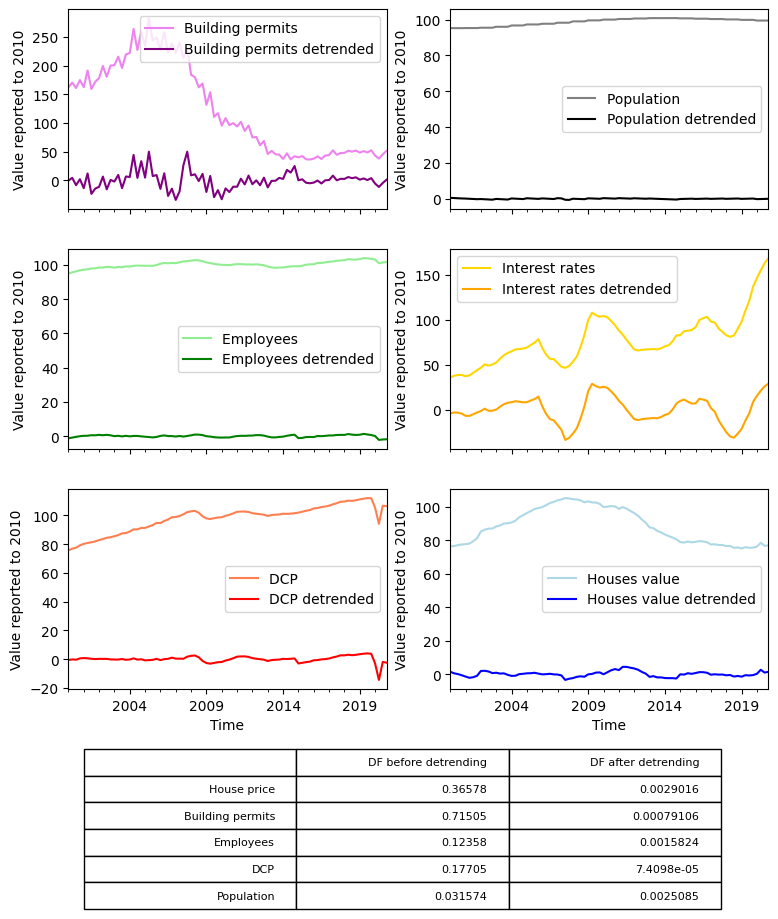

In [19]:
fig , axis = plt.subplots(3 , 2 , figsize=(10, 10) , sharex=True )
tot.plot( 'TIME' , 'Case' , ax=axis[2,1] , color = 'lightblue' , label = 'Houses value ' )
tot.plot( 'TIME' , 'Lavoratori' , ax=axis[1,0] , color = 'lightgreen' , label = 'Employees ')
tot.plot( 'TIME' , 'PIL' , ax=axis[2,0] , color ='coral' , label = 'DCP ')
tot.plot( 'TIME' , 'Popolazione' , ax=axis[0,1] , color = 'gray' , label = 'Population ')
tot.plot( 'TIME' , 'Tassi' , ax=axis[1,1] , color = 'gold'  , label = 'Interest rates ')
tot.plot( 'TIME' , 'Permessi' , ax=axis[0,0] , color = 'violet' , label = 'Building permits ')

Traslato.plot( 'TIME' , 'Case' , ax=axis[2,1] , color = 'blue' , label = 'Houses value detrended' )
Traslato.plot( 'TIME' , 'Lavoratori' , ax=axis[1,0] , color = 'green' , label = 'Employees detrended')
Traslato.plot( 'TIME' , 'PIL' , ax=axis[2,0] , color ='red'  , label = 'DCP detrended')
Traslato.plot( 'TIME' , 'Popolazione' , ax=axis[0,1] , color = 'black' , label = 'Population detrended')
Traslato.plot( 'TIME' , 'Tassi' , ax=axis[1,1] , color = 'orange'  , label = 'Interest rates detrended')
Traslato.plot( 'TIME' , 'Permessi' , ax=axis[0,0] , color = 'purple' , label = 'Building permits detrended')

plt.subplots_adjust(left=0.2, bottom=0.2)
table = plt.table(cellText=cella , bbox=[-1.15, -1.1 , 2, 0.8] )
table.set_fontsize(15)
table.scale(1.5, 1.5) 

for i in range(3):
    for j in range(2):
        axis[i,j].legend()
        axis[i,j].set_xlabel('Time')
        axis[i,j].set_ylabel('Value reported to 2010')

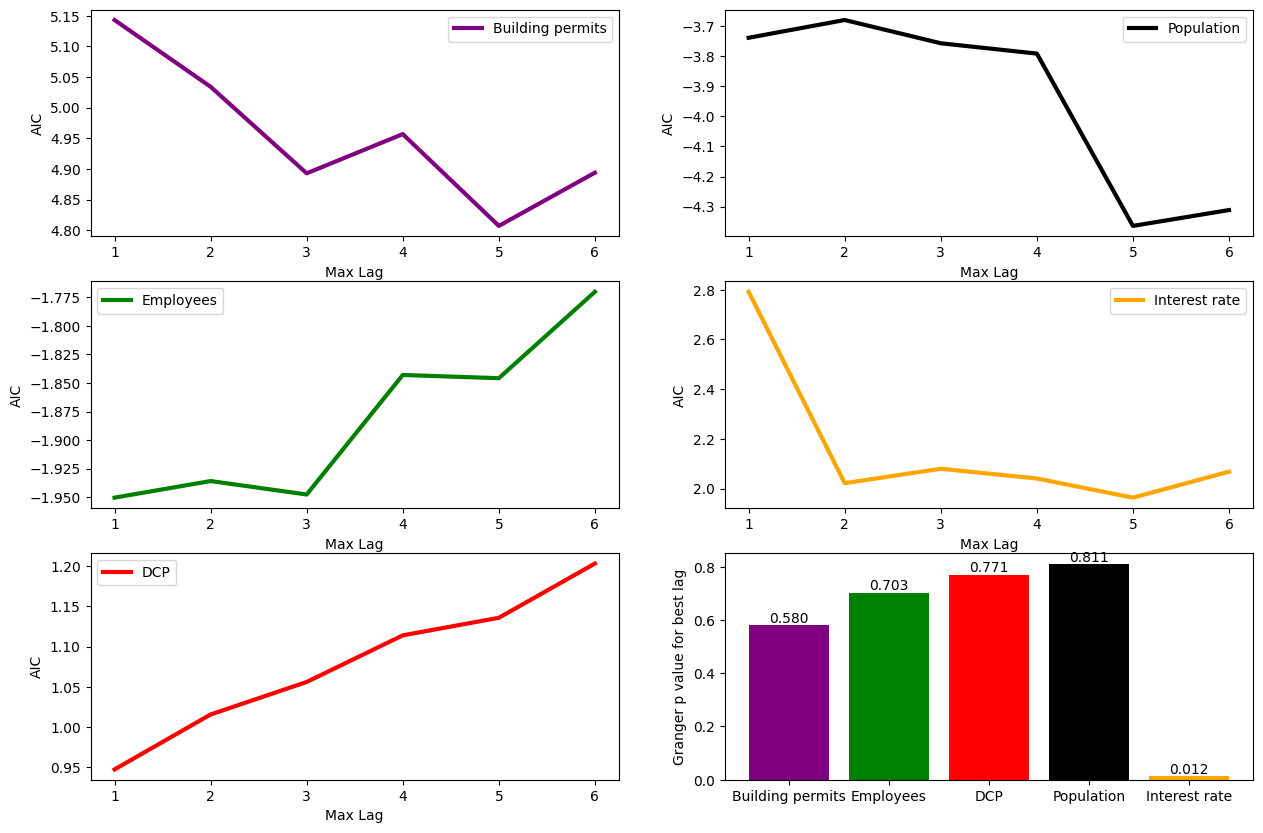

In [20]:
fig , axis = plt.subplots(3 , 2 , figsize=(15, 10))
x = [1,2,3,4,5,6]
nomi = ['Building permits', 'Employees', 'DCP', 'Population', 'Interest rate']
colori = ['purple' , 'green' , 'red' , 'black' , 'orange' ]
pvalues = [Grangers[0][1] , Grangers[1][1] , Grangers[2][1], Grangers[3][1] , Grangers[4][1]]

axis[0,0].plot(x , Grangers[0][3] , color = 'purple' , label = 'Building permits' , lw = 3)
axis[1,0].plot(x , Grangers[1][3] , color = 'green' , label = 'Employees' , lw = 3)
axis[2,0].plot(x , Grangers[2][3] , color = 'red' , label = 'DCP' , lw = 3)
axis[0,1].plot(x , Grangers[3][3] , color = 'black' , label = 'Population' , lw = 3)
axis[1,1].plot(x , Grangers[4][3] , color = 'orange' , label = 'Interest rate' , lw = 3)
axis[2,1].bar(nomi, pvalues, color = colori , label = nomi)

for i in range(3):
    for j in range(2):
        if (i,j) != (2,1) : 
            axis[i,j].set_xlabel('Max Lag')
            axis[i,j].set_ylabel('AIC')
            axis[i,j].set_xticks(x)
            axis[i,j].legend()

for i in range(5) : 
    axis[2,1].set_ylabel('Granger p value for best lag')
    axis[2,1].text(nomi[i] , pvalues[i]+0.01 , '{:.3f}'.format(pvalues[i]) , horizontalalignment = 'center')